# Phase 1
Analysing AML microarray.

## 1. Prepairing Data

### Installing Packages

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos='http://cran.us.r-project.org')
BiocManager::install()
BiocManager::install("GEOquery")

install.packages("limma")
install.packages("umap")
install.packages("maptools")
install.packages("corrplot")
install.packages("pheatmap")
install.packages("reshape2")

### Libraries

In [ ]:
%%R

library(Biobase)
library(GEOquery)
library(limma)
library(umap)
library(maptools)
library(tidyr)
library(dplyr)
library(ggplot2)
library(devtools)
install_github("vqv/ggbiplot")
library(ggbiplot)
library(data.table)
library(corrplot)
library(pheatmap)
library(reshape2)
library(plyr)

### Loading Data

In [ ]:
%%R

gds <- getGEO("GSE48558", GSEMatrix = TRUE, AnnotGPL=TRUE)
show(gds)
gds48558 <- gds[[1]]

fvarLabels(gds48558) <- make.names(fvarLabels(gds48558))

# group membership for all samples
gsms <- paste0("1111111111111XXXXXXXXXXXXXXXXXXXXXXXXXXX0XXX0XXXXX",
               "XXXXXXXXXXXXXXXXXX0X0XXX0X0000X0XX00XX00X0X0X0X0X0",
               "XXX0XXX0XXXXXXXXXXXXXXXXXXXXXXXXXXXXX0000000110111",
               "00000000000000000000")
sml <- strsplit(gsms, split="")[[1]]

sel <- which(sml != "X")
sml <- sml[sel]
gds48558 <- gds48558[ ,sel]

gs <- factor(sml)
groups <- make.names(c("Healthy", "AML"))
levels(gs) <- groups
gds48558$group <- gs

### Alternative
An alternative way to download data.

In [ ]:
!wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/soft/GSE48558_family.soft.gz
!wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/miniml/GSE48558_family.xml.tgz
!wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE48nnn/GSE48558/matrix/GSE48558_series_matrix.txt.gz
!wget -c https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE48558&format=file

In [ ]:
%%R
gds858 <- getGEO(filename='GSE48558_series_matrix.txt.gz')

### Data Properties

In [ ]:
%%R

expr <- exprs(gds48558)
features <- fData(gds48558)
phenotypes <- pData(gds48558)
dim(gds48558)

Features  Samples 
   32321       67 


In [ ]:
%%R

# Print column names of phenotypes and features
print(colnames(phenotypes))
print(colnames(features))

 [1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "growth_protocol_ch1"     "molecule_ch1"           
[13] "extract_protocol_ch1"    "label_ch1"              
[15] "label_protocol_ch1"      "taxid_ch1"              
[17] "hyb_protocol"            "scan_protocol"          
[19] "description"             "data_processing"        
[21] "platform_id"             "contact_name"           
[23] "contact_email"           "contact_institute"      
[25] "contact_address"         "contact_city"           
[27] "contact_zip/postal_code" "contact_country"        
[29] "supplementary_file"      "data_row_count"         
[31] "relation"                "phenotype:ch1"          
 [1] "ID"              "GB_LIST"         "SPOT_ID"         "seqname"        
 [5] "RANGE

### Checking the Quality of Data

#### Normalizing the Data

In [ ]:
%%R

# log2 transform
qx <- as.numeric(quantile(expr, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) || (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { 
    expr[which(expr <= 0)] <- NaN
    expr <- log2(expr) 
}

dim(expr)

[1] 32321    67


### Differential Expression Analysis

In [ ]:
%%R

design <- model.matrix(~group + 0, gds48558)
colnames(design) <- levels(gs)

fit <- lmFit(gds48558, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)

tT <- subset(tT, select=c("Gene.symbol", "Gene.ID","adj.P.Val","logFC"))
write.table(tT, file='AML_Healthy.tsv', row.names=F, sep="\t", quote=F)

head(tT)

        Gene.symbol Gene.ID    adj.P.Val     logFC
8016932         MPO    4353 3.617813e-19 -5.563501
7970737        FLT3    2322 4.835716e-19 -5.250065
7989647    KIAA0101    9768 6.308160e-19 -4.559135
7982663       BUB1B     701 1.664043e-18 -2.756554
8083422      SUCNR1   56670 1.938573e-18 -2.996816
7926259       MCM10   55388 3.712137e-18 -2.318848


In [ ]:
%%R

result <- read.table(file = 'AML_Healthy.tsv', sep = '\t', header = TRUE)
aml.up <- subset(result, logFC > 1 & adj.P.Val < 0.05)
# aml.up.gene <- unique(aml.up$Gene.symbol)
# aml.up.gene <- sub("///.*", "", aml.up.gene)
aml.up.gene <- unique(as.character(strsplit2(aml.up$Gene.symbol, "///")))
write.table(aml.up.gene, file='AML_Healthy_Up.tsv', row.names=F, col.names=F, quote=F)

aml.down <- subset(result, logFC < -1 & adj.P.Val < 0.05)
aml.down.gene <- unique(as.character(strsplit2(aml.down$Gene.symbol, "///")))
write.table(aml.down.gene, file='AML_Healthy_Down.tsv', row.names=F, col.names=F, quote=F)

head(aml.up.gene)

[1] "STK38" "CBX7"  "PLCL2" "PECR"  ""      "HLA-F"


#### Histogram of P-values for all genes

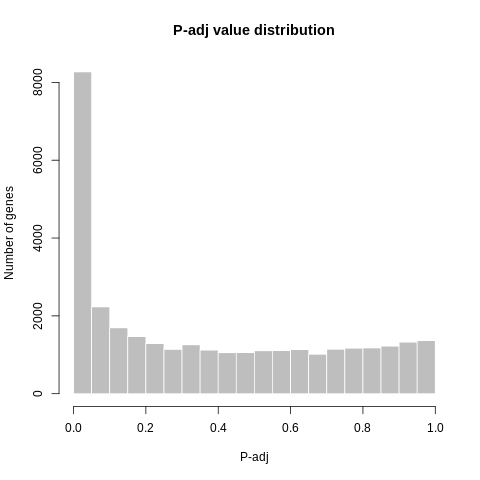

In [ ]:
%%R

tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
     ylab = "Number of genes", main = "P-adj value distribution")

#### Q-Q plot for t-statistic

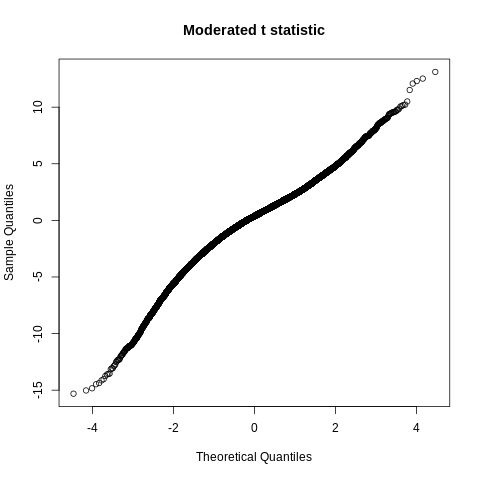

In [ ]:
%%R

t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

#### Volcano Plot (log P-value vs log fold change)

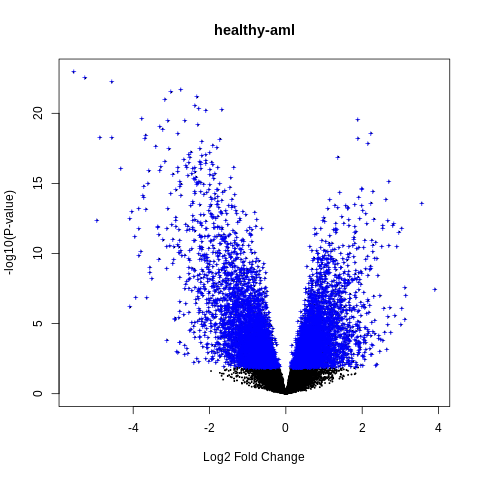

In [ ]:
%%R

# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)

colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
            highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

#### MD plot (log fold change vs mean log expression)

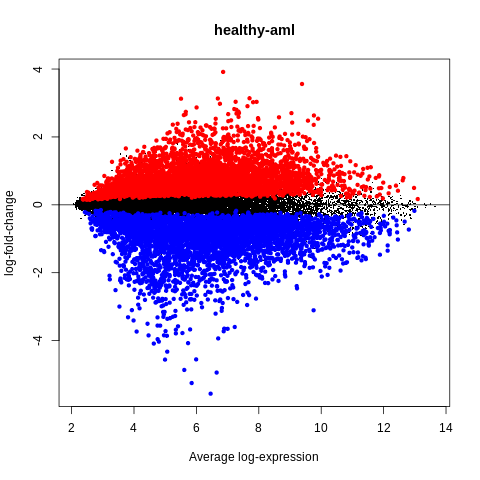

In [ ]:
%%R

# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

#### Keeping a Subset of Columns

In [ ]:
%%R

# Only keep subset of columns needed for analysis
phenotypes_filtered <- dplyr::select(phenotypes, title, "phenotype:ch1", source_name_ch1, geo_accession)
features_filtered <- dplyr::select(features, ID, SPOT_ID, total_probes)

expr_df <- data.frame(expr)

head(phenotypes_filtered)

                           title phenotype:ch1 source_name_ch1 geo_accession
GSM1180750 Primary AML sample 40      Leukemia     AML Patient    GSM1180750
GSM1180751 Primary AML sample 41      Leukemia     AML Patient    GSM1180751
GSM1180752 Primary AML sample 42      Leukemia     AML Patient    GSM1180752
GSM1180753 Primary AML sample 44      Leukemia     AML Patient    GSM1180753
GSM1180754  Primary AML sample 1      Leukemia     AML Patient    GSM1180754
GSM1180755  Primary AML sample 3      Leukemia     AML Patient    GSM1180755


In [ ]:
%%R

# Gather expression columns of expr_df and print structure of dat
data <- tidyr::gather(data = expr_df, key = geo_accession,
              value = expression, starts_with("GSM"))
head(data)

  geo_accession expression
1    GSM1180750   5.635547
2    GSM1180750   6.640414
3    GSM1180750   5.108161
4    GSM1180750   8.414047
5    GSM1180750   2.280691
6    GSM1180750   4.123770


#### Gathering Data

In [ ]:
%%R

data <- data.frame(expr) %>%
        gather(key = geo_accession, value = expression, starts_with("GSM")) %>%
        full_join(phenotypes, by = "geo_accession") %>%
        select(title, "phenotype:ch1", source_name_ch1, geo_accession, expression)
colnames(data) <- c("Title", "Phenotype", "SourceName", "Accession", "Expression")

head(data)

                  Title Phenotype  SourceName  Accession Expression
1 Primary AML sample 40  Leukemia AML Patient GSM1180750   5.635547
2 Primary AML sample 40  Leukemia AML Patient GSM1180750   6.640414
3 Primary AML sample 40  Leukemia AML Patient GSM1180750   5.108161
4 Primary AML sample 40  Leukemia AML Patient GSM1180750   8.414047
5 Primary AML sample 40  Leukemia AML Patient GSM1180750   2.280691
6 Primary AML sample 40  Leukemia AML Patient GSM1180750   4.123770


In [ ]:
%%R

normal <- dplyr::filter(data, Phenotype == "Normal")
patient <- dplyr::filter(data, SourceName == "AML Patient")

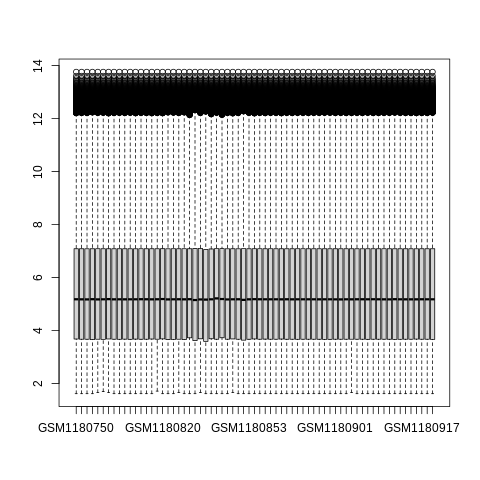

In [ ]:
%%R

boxplot(expr_df)

### General Expression Data Analysis

#### Expression Value Distribution

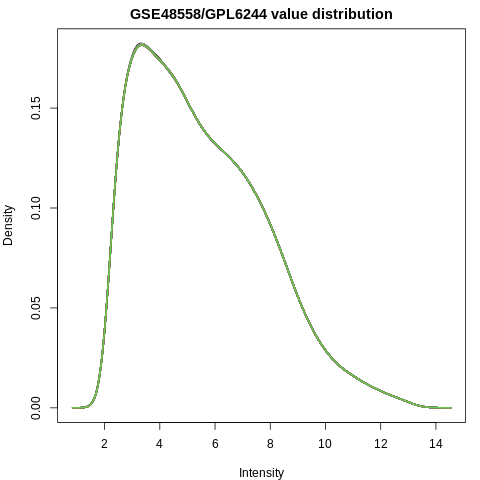

In [ ]:
%%R

par(mar=c(4,4,2,1))
title <- paste("GSE48558", "/", annotation(gds48558), " value distribution", sep ="")
plotDensities(expr, main=title, legend=F)

#### Mean Variance Trend
We eliminate rows with NAs.

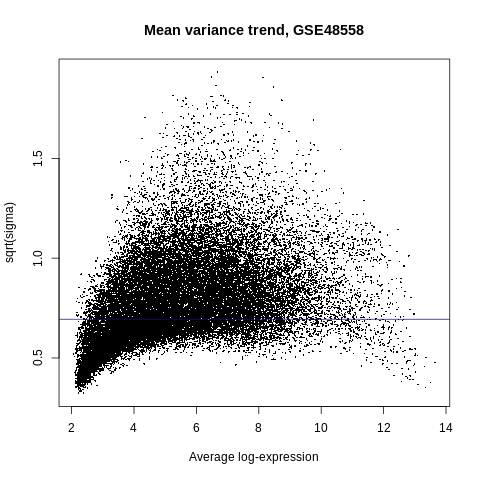

In [ ]:
%%R

expr <- na.omit(expr)
plotSA(fit2, main="Mean variance trend, GSE48558")

#### UMAP Plot (multi-dimensional scaling)
We remove duplicates from data.

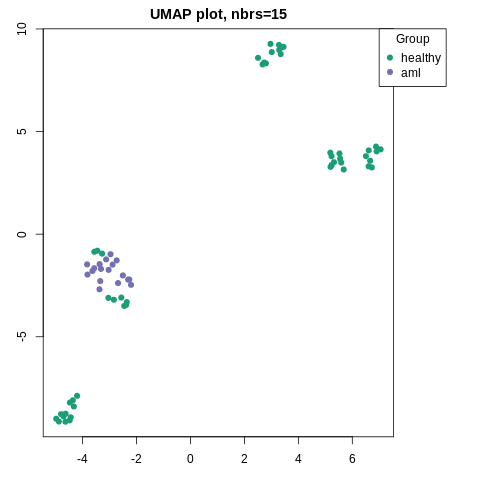

In [ ]:
%%R

expr <- expr[!duplicated(expr), ]  # remove duplicates
ump <- umap(t(expr), n_neighbors = 15, random_state = 123)
par(mar=c(3,3,2,6), xpd=TRUE)
plot(ump$layout, main="UMAP plot, nbrs=15", xlab="", ylab="", col=gs, pch=20, cex=1.5)
legend("topright", inset=c(-0.15,0), legend=levels(gs), pch=20,
col=1:nlevels(gs), title="Group", pt.cex=1.5)
# pointLabel(ump$layout, labels = rownames(ump$layout), method="SANN", cex=0.6)

## 3. Dimensionality Reduction

### PCA

In [ ]:
# todo
%%R
pca <- prcomp(expr, center=TRUE, scale.=TRUE)

summary(pca)

Importance of components:
                          PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     7.6458 1.57065 1.12017 1.00198 0.78282 0.61918 0.52199
Proportion of Variance 0.8725 0.03682 0.01873 0.01498 0.00915 0.00572 0.00407
Cumulative Proportion  0.8725 0.90933 0.92806 0.94304 0.95219 0.95791 0.96198
                          PC8     PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     0.4404 0.39553 0.37623 0.35232 0.31759 0.3058 0.27909
Proportion of Variance 0.0029 0.00233 0.00211 0.00185 0.00151 0.0014 0.00116
Cumulative Proportion  0.9649 0.96721 0.96932 0.97117 0.97268 0.9741 0.97523
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.27612 0.26947 0.26452 0.25317 0.24683 0.23961 0.23592
Proportion of Variance 0.00114 0.00108 0.00104 0.00096 0.00091 0.00086 0.00083
Cumulative Proportion  0.97637 0.97746 0.97850 0.97946 0.98037 0.98122 0.98205
                          PC22    PC23

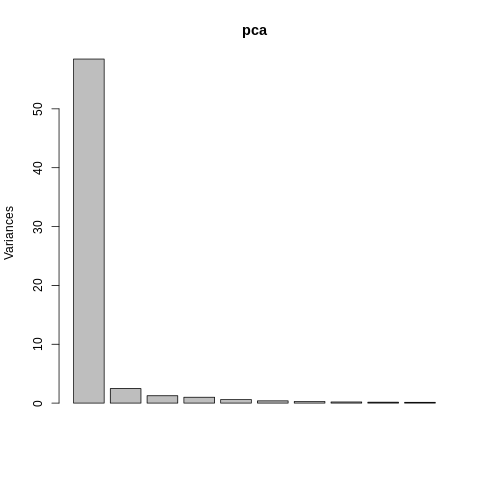

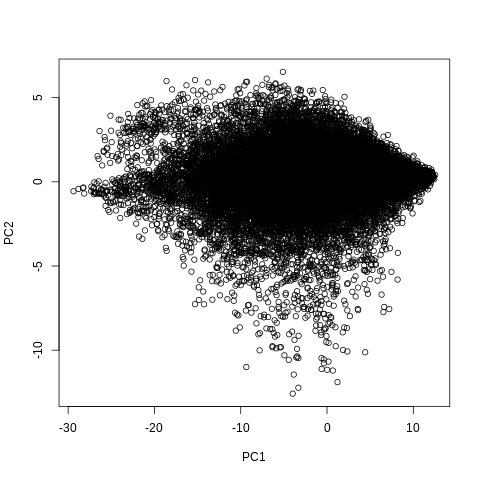

In [ ]:
%%R

plot(pca)
plot(pca$x[, 1:2])

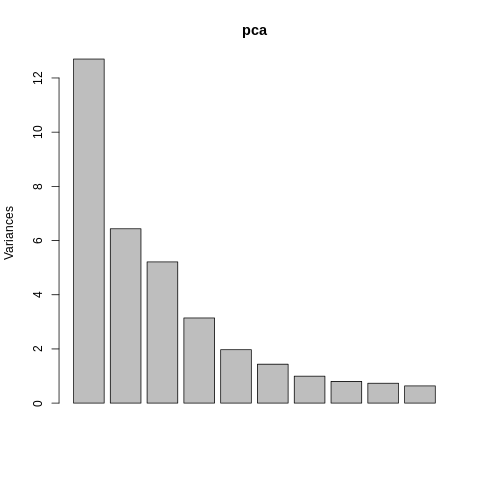

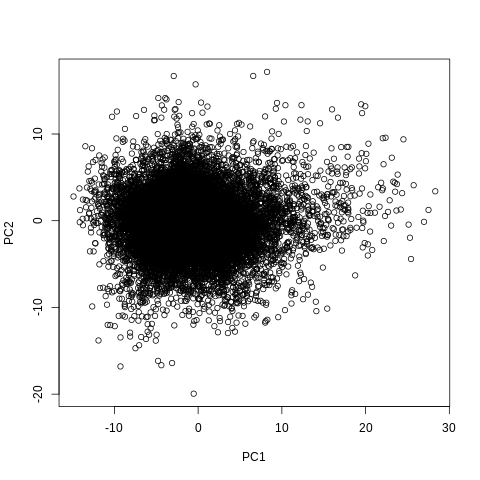

In [ ]:
%%R

expr.scale = t(scale(t(expr), scale = F))
pca <- prcomp(expr.scale)
plot(pca)
plot(pca$x[, 1:2])

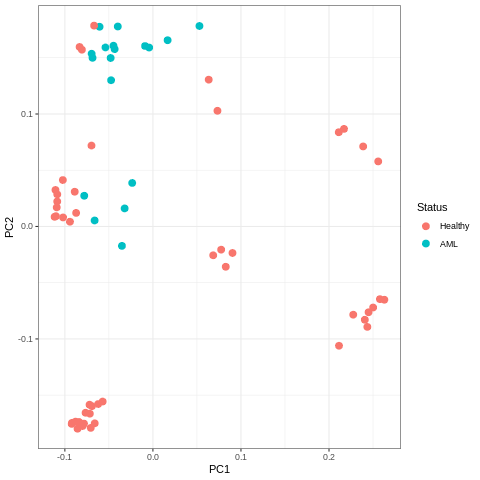

In [ ]:
%%R

pcar <- data.frame(pca$r[, 1:3], Status = gds48558$group)

ggplot(pcar, aes(PC1, PC2, color = Status)) + geom_point(size = 3) + theme_bw()
# ggsave("pca_samples.pdf")

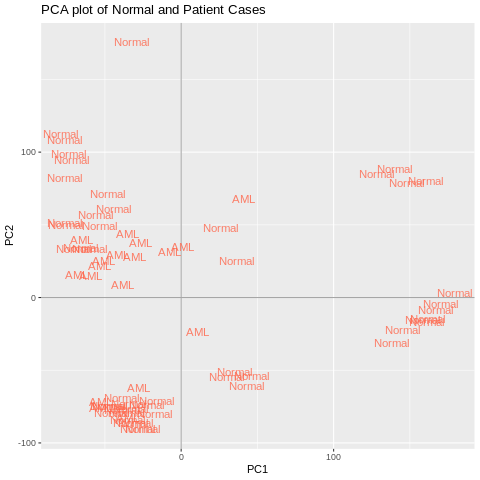

In [ ]:
%%R

# ggbiplot(pca)

scores = as.data.frame(prcomp(t(expr), center=TRUE, scale.=TRUE)$x)

ggplot(data = scores, aes(x = PC1, y = PC2, label = gds48558$group)) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(colour = "tomato", alpha = 0.8, size = 4) +
  ggtitle("PCA plot of Normal and Patient Cases")

### Correlation

In [ ]:
%%R

pheatmap(cor(expr), filename="CorHeatmap.pdf", labels_row = status, labels_col = status, width = 16, height = 16, borderColor= NA)

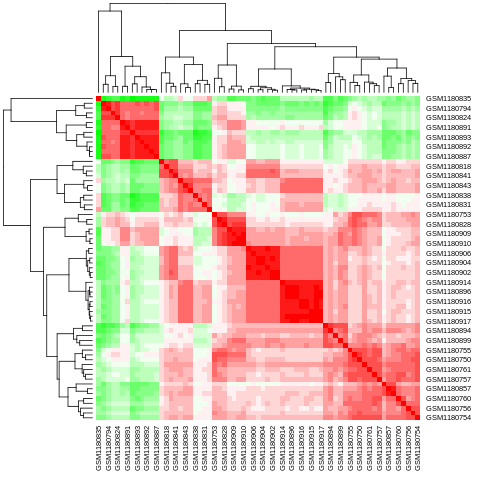

In [ ]:

res <- cor(expr_df)
# corrplot(res)
palette <- colorRampPalette(c("green", "white", "red")) (20)
heatmap(x = res, col=palette, symm=TRUE)